In [1]:
%matplotlib inline
import numpy as np
from IPython.display import clear_output
from numpy import linalg as LA
import matplotlib.pyplot as pl
import matplotlib
from mpl_toolkits.mplot3d.axes3d import Axes3D

from scipy.optimize import minimize
from scipy import optimize
import f_class
from GP import GP
from GP_grad import GP_grad
from lineGD import lineGD
import time
from torch.quasirandom import SobolEngine
import sobol_seq
from utils import *

eps = np.sqrt(np.finfo(float).eps)

Noise = False
Noise_level = 0.00 # noise-free

#### High-dimensional $f$

In [2]:
objective = f_class.Hartmann_6(Noise, Noise_level)
objective = f_class.Ackley(Noise, Noise_level, dim=13)
# objective = f_class.Michalewicz(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level, dim=20)
# objective = f_class.Rosenbrock(Noise, Noise_level)
# objective = f_class.Griewank(Noise, Noise_level)
# objective = f_class.Levy(Noise, Noise_level, dim=10) 
# objective = f_class.Rastrigin(Noise, Noise_level, dim=10)
# objective = f_class.Shubert_2(Noise, Noise_level)
# objective = f_class.Ackley_2(Noise, Noise_level)

f = objective.func
clean_f = lambda x: f_class.Hartmann_6().func(x)
clean_f = lambda x: f_class.Ackley(dim=13).func(x)
# clean_f = lambda x: f_class.Michalewicz().func(x)
# clean_f = lambda x: f_class.Schwefel(dim=20).func(x)
# clean_f = lambda x: f_class.Rosenbrock().func(x)
# clean_f = lambda x: f_class.Griewank().func(x)
# clean_f = lambda x: f_class.Levy(dim=10).func(x)
# clean_f = lambda x: f_class.Rastrigin(dim=10).func(x)
# clean_f = lambda x: f_class.Shubert_2().func(x)
# clean_f = lambda x: f_class.Ackley_2().func(x)  

B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(B.T) 
lb = B[:, 0]; ub = B[:, 1]

dim = objective.input_dim
print('dim: ', dim)
# print(f( np.array([dim*[1], dim*[1]])))

[[-5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]]
dim:  13


In [3]:
# assuming B = L^d, cube
Diam = LA.norm(ub - lb)
Len = (ub - lb)[0]
Diam

54.08326913195984

#### Finding Optimized Hyperparameter $\sigma, \ell \rightarrow$ Online Update of Hyperparameter

In [4]:
# set seed
seed = 0
def random_draw(n_random_draws=3):
    """ samples some points"""
    # should draw randomly
    return np.random.uniform(lb, ub, size=(n_random_draws, dim))

def optimize_hyper(lb, ub, sample_size=2000):
#     np.random.seed(seed)
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

# # find optimized hyper, if online, skip this part
# gp = GP_grad(B, Noise, Noise_level)
# (ls, var) = optimize_hyper(lb, ub, sample_size=2000)
# del gp
# (ls, var)

### Grid

In [5]:
# n_Grid = dim
# G = np.zeros((dim, n_Grid))
# for i in range(dim):
#     G[i] = np.linspace(lb[i], ub[i], n_Grid)

# Grid = np.vstack( [axis.flatten() for axis in np.meshgrid(*(G[i] for i in range(G.shape[0])))] ).T
# Grid.shape

### Grid Approx Gradient

In [6]:
# # approximate the gradient
# from scipy import optimize

# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape

In [7]:
# # 3d plot of the gradient
# # approximate the gradient
# from scipy import optimize

# # optimize.approx_fprime(x, clean_Ackley_1d, eps)
# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape
# g1 = approx_grad[:, 0]
# g2 = approx_grad[:, 1]
# g1, g2

### Trust Region GD-1

In [8]:
MAX = 300 # function observations

##### 1. Setup with random points

In [9]:
# initial data
setup = dim
# X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = from_unit_cube(latin_hypercube(setup, dim), lb, ub)
X_fix = X

history = [(x, f(x)) for x in X]

##### 2. Build Trust Region 

In [10]:
# return x inside trust region ball
def build_TR(X, TR_c, TR_r):
    X_TR = np.vstack(list(filter(lambda x: TR_r >= LA.norm(x - TR_c), [x for x in X])))
    return X_TR

In [11]:
# R = 0.5 * Diam
# X_TR = build_TR(X, X[0], R)

# pl.figure(figsize=(6, 6), dpi=80)
# pl.plot(X[:, 0], X[:, 1], 'o', linewidth=1, markersize=8)
# pl.plot(X_TR[:, 0], X_TR[:, 1], 'x', linewidth=2, markersize=8)
# pl.xlim(B[0])
# pl.ylim(B[1])

# pl.gca().add_patch(pl.Circle(X[0], R, color='blue', alpha=0.1))
# pl.show()

### Trust Region GD-1

In [12]:
np.set_printoptions(precision=4)
cost = setup
xc = X[np.argmin(f(X))]
f_xc = f(xc)
xc
# gp.posterior(w), gp._normal(f(w))
# gp.grad(w), gp.grad_sample(w), optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)

array([ 6.236 , -1.8227, -3.2142, -0.4366, -1.8607, -0.3543,  1.5209,
        4.4028,  0.9402, -0.631 , -0.9736,  1.1984,  3.4339])

In [13]:
# # plot
# n_Grid = 100
# x1 = np.linspace(lb[0], ub[0], n_Grid)
# x2 = np.linspace(lb[1], ub[1], n_Grid)

# X1, X2 = np.meshgrid(x1, x2)
# Grid = np.vstack((X1.flatten(), X2.flatten())).T
# Grid.shape

In [14]:
MAX_Fal = 6
MAX_Imp = 3

MAX_R = 1.6 * Diam
MIN_R = (1/2)**6 * MAX_R

MIN_R, MAX_R

(1.352081728298996, 86.53323061113575)

In [15]:
# L0: starting length of trust region
GD_Fal = 0
GD_Imp = 0
R = 0.5 * MAX_R # set 1/2 of MAX_R could be faster
R

43.266615305567875

In [16]:
while MAX >= cost:
    if cost != setup:
        print('### New GD ###')
        X_ = from_unit_cube(latin_hypercube(setup, dim), lb, ub)
        cost += setup
        X = np.vstack([X, X_])
        xc = X_[np.argmin(f(X_))]
        f_xc = f(xc)
        GD_Fal = 0
        GD_Imp = 0
        R = 0.5 * MAX_R
        MIN_R = MIN_R / 2
        
    while MAX >= cost and MAX_R >= R >= MIN_R:
        print(cost, end = '. ')
        print('R = ', R)

        # new TR = (xc, R)
        Xtr = build_TR(X, xc, R)  # get the points only inside the trust region
        print(Xtr.shape)

        # fit a new GP with pts inside TR
        gp = GP_grad(B, Noise, Noise_level, compress=True)
        gp.set_data(Xtr, f(Xtr))
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        gp.fit()

        # GD from xc to get new x
        GD = lineGD(gp, xc, f, R)
        x, _ = GD.update(commit=True)
        X = np.vstack([X, x])
        cost += 1

        # update GD_Fal & GD_Imp
        delta = np.abs(1e-3 * f_xc)
        if f(x) < f_xc - delta:
            GD_Fal = 0
            GD_Imp += 1
        else:
            GD_Fal += 1
            GD_Imp = 0

        if f(x) < f_xc:
            # shift xc
            xc = x
            f_xc = f(xc)

        if MAX_Fal == GD_Fal:
            # shift the center and shrink the space
    #         R = max(R / 2, MIN_R)
            R = R / 2
            GD_Fal = 0
            print('Shrink TR: %.4f ' % R)

        if MAX_Imp == GD_Imp: 
    #         R = min(R * 2, MAX_R)
            R = R * 2
            GD_Imp = 0
            print('Expand TR: %.4f ' % R)

        # verbose
        y_best = np.min(f(X))
        print('x = ', x)
        print('    f(x): %.4f ' % f(x).item())
        print('    y best %.4f ' %  y_best)
        history.append( (x, f(x)) )
        print()

13. R =  43.266615305567875
(13, 13)
lr =  9.35060446452149
x =  [[ 6.236  -1.8227 -3.2142 -0.4366 -1.8607  0.3547  1.5209  4.4028  0.9402
  -0.631  -0.9736  1.1984  3.4339]]
    f(x): 10.1161 
    y best 10.1159 

14. R =  43.266615305567875
(14, 13)
lr =  43.266615305567875
x =  [[ 6.236  -1.8227 -3.2142 -0.4366 -1.8607 -0.3543  1.5209  4.4028  0.9402
   0.6229 -0.9736  1.1984  3.4339]]
    f(x): 10.1181 
    y best 10.1159 

15. R =  43.266615305567875
(15, 13)
lr =  4.7430414805501115
x =  [[ 6.236  -1.8227 -3.2142 -0.4366 -1.8607 -0.3543  1.5209  4.4028  0.9402
  -0.631  -0.9736  1.1984  1.6202]]
    f(x): 9.7830 
    y best 9.7830 

16. R =  43.266615305567875
(16, 13)
lr =  43.266615305567875
x =  [[ 6.236  -1.8227 -3.2142 -0.4366 -1.8607 -0.3543  1.5209  4.4028  0.9402
  -0.631  -0.9736 -0.2519  1.6202]]
    f(x): 9.7558 
    y best 9.7558 

17. R =  43.266615305567875
(17, 13)
lr =  -38.81910232027768
x =  [[ 6.236  -1.8227 -3.2142 -0.4366 -1.8607 -0.3543  1.5209  4.4028  0.94

lr =  21.633307652783937
x =  [[ 1.7889  0.3377 -1.0131 -0.4366 -1.8607 -0.3543  1.5209 -0.4549 -0.9516
  -0.631   0.9539 -0.2519 -0.5582]]
    f(x): 5.5042 
    y best 5.5042 

52. R =  21.633307652783937
(50, 13)
lr =  20.261123732223368
x =  [[ 1.7889  0.3377 -1.0131 -0.4366 -1.8607 -0.3543  1.5209 -0.4549 -0.9516
  -0.631  -1.1782 -0.2519 -0.5582]]
    f(x): 5.5974 
    y best 5.5042 

53. R =  21.633307652783937
(51, 13)
lr =  4.168766485800702
x =  [[ 1.7889  0.3377 -1.0131 -0.4366 -1.8607 -0.3543  1.5209 -0.4549 -0.9516
   1.353   0.9539 -0.2519 -0.5582]]
    f(x): 5.6721 
    y best 5.5042 

54. R =  21.633307652783937
(52, 13)
lr =  -5.868786480402182
x =  [[ 1.7889  0.3377 -1.0131 -2.5741 -1.8607 -0.3543  1.5209 -0.4549 -0.9516
  -0.631   0.9539 -0.2519 -0.5582]]
    f(x): 6.2095 
    y best 5.5042 

55. R =  21.633307652783937
(53, 13)
lr =  10.54724011883073
x =  [[ 1.7889  0.3377 -3.1949 -0.4366 -1.8607 -0.3543  1.5209 -0.4549 -0.9516
  -0.631   0.9539 -0.2519 -0.5582]]
  

lr =  -5.9907065425343395
x =  [[-0.464   0.3377  0.2867 -0.4366  0.2859 -0.3543 -0.0588 -0.1932  0.0346
  -0.4617 -0.0686 -0.2519  0.5274]]
    f(x): 3.1547 
    y best 3.1547 

90. R =  10.816653826391969
(77, 13)
lr =  -3.6855161590728933
x =  [[-0.464   0.3377  0.2867 -0.4366  0.2859 -0.3543 -0.0588 -0.1932  0.0346
  -0.4617 -0.0686 -0.2519 -0.6594]]
    f(x): 3.1920 
    y best 3.1547 

91. R =  10.816653826391969
(78, 13)
lr =  2.9300878114477347
x =  [[-0.464  -0.8853  0.2867 -0.4366  0.2859 -0.3543 -0.0588 -0.1932  0.0346
  -0.4617 -0.0686 -0.2519  0.5274]]
    f(x): 3.3308 
    y best 3.1547 

92. R =  10.816653826391969
(79, 13)
lr =  5.6460779164172274
x =  [[-0.464   0.3377  0.2867 -0.4366  0.2859 -0.3543 -0.0588 -0.1932  0.0346
   0.7055 -0.0686 -0.2519  0.5274]]
    f(x): 3.2269 
    y best 3.1547 

93. R =  10.816653826391969
(80, 13)
lr =  2.9223467860156456
x =  [[-0.464   0.3377  0.2867  0.6908  0.2859 -0.3543 -0.0588 -0.1932  0.0346
  -0.4617 -0.0686 -0.2519  0.5274]

lr =  -1.0947560866324488
x =  [[ 0.5775 -0.2373  0.2867 -0.1062  0.2859 -0.0692  0.046  -0.1932  0.0346
   0.1062 -0.0686 -0.2519 -0.228 ]]
    f(x): 2.2334 
    y best 1.7839 

128. R =  1.352081728298996
(23, 13)
lr =  1.352081728298996
x =  [[ 0.0498 -0.2373  0.2867 -0.1062 -0.0434 -0.0692  0.046  -0.1932  0.0346
   0.1062 -0.0686 -0.2519 -0.228 ]]
    f(x): 1.5575 
    y best 1.5575 

129. R =  1.352081728298996
(22, 13)
lr =  1.352081728298996
x =  [[ 0.0498 -0.2373  0.2867 -0.1062 -0.0434 -0.0692  0.046   0.188   0.0346
   0.1062 -0.0686 -0.2519 -0.228 ]]
    f(x): 1.5514 
    y best 1.5514 

130. R =  1.352081728298996
(21, 13)
lr =  1.0730075801924124
x =  [[ 0.0498 -0.2373  0.2867 -0.1062 -0.0434 -0.0692 -0.3734  0.188   0.0346
   0.1062 -0.0686 -0.2519 -0.228 ]]
    f(x): 1.8833 
    y best 1.5514 

131. R =  1.352081728298996
(22, 13)
lr =  1.352081728298996
x =  [[ 0.0498 -0.2373 -0.0249 -0.1062 -0.0434 -0.0692  0.046   0.188   0.0346
   0.1062 -0.0686 -0.2519 -0.228 ]]
  

lr =  21.633307652783937
x =  [[ 3.527  -3.2663  0.9261  1.8012 -3.6816 -4.1491 -4.5491  3.9395 -5.
   2.6617 -0.305  -1.039   3.6645]]
    f(x): 11.2957 
    y best 1.1657 

179. R =  21.633307652783937
(166, 13)
lr =  -15.665498645119403
Shrink TR: 10.8167 
x =  [[ 3.527  -3.2663  0.9261  1.8012 -3.6816 -4.1491  3.0682  3.9395 -5.
  -5.     -0.305  -1.039   3.6645]]
    f(x): 11.1348 
    y best 1.1657 

180. R =  10.816653826391969
(70, 13)
lr =  -10.816653826391969
x =  [[ 3.527  -3.2663  0.9261  1.8012 -3.6816 -4.1491  3.0682  3.9395  1.1626
   2.6617 -0.305  -1.039   3.6645]]
    f(x): 10.2297 
    y best 1.1657 

181. R =  10.816653826391969
(131, 13)
lr =  10.816653826391969
x =  [[ 3.527  -3.2663  6.552   1.8012 -3.6816 -4.1491  3.0682  3.9395  1.1626
   2.6617 -0.305  -1.039   3.6645]]
    f(x): 11.5018 
    y best 1.1657 

182. R =  10.816653826391969
(132, 13)
lr =  -10.816653826391969
x =  [[ 3.527  -3.2663  0.9261  1.8012 -3.6816 -4.1491  3.0682  3.9395  1.1626
   2.6617 

lr =  10.816653826391969
x =  [[ 1.1114 -1.3804  0.9261  0.4767 -1.3703 -3.3181  3.0682 -0.7539 -3.9204
   2.6617 -0.305  -1.039   0.0993]]
    f(x): 8.1179 
    y best 1.1657 

217. R =  10.816653826391969
(168, 13)
lr =  -10.816653826391969
x =  [[ 1.1114 -1.3804  0.9261  0.4767 -1.3703 -3.3181  3.0682 -0.7539  1.1626
   2.6617  5.6835 -1.039   0.0993]]
    f(x): 9.0071 
    y best 1.1657 

218. R =  10.816653826391969
(169, 13)
lr =  -10.816653826391969
x =  [[ 1.1114 -1.3804  0.9261  0.4767 -1.3703 -3.3181  9.1223 -0.7539  1.1626
   2.6617 -0.305  -1.039   0.0993]]
    f(x): 10.4738 
    y best 1.1657 

219. R =  10.816653826391969
(170, 13)
lr =  10.816653826391969
x =  [[ 1.1114 -1.3804  0.9261  0.4767 -1.3703 -3.3181  3.0682 -0.7539  1.1626
   2.6617 -0.305   4.737   0.0993]]
    f(x): 8.6007 
    y best 1.1657 

220. R =  10.816653826391969
(171, 13)
lr =  10.816653826391969
Shrink TR: 5.4083 
x =  [[ 1.1114 -1.3804  0.9261  5.1164 -1.3703 -3.3181  3.0682 -0.7539  1.1626
   2.6

lr =  5.408326913195984
x =  [[ 0.8598  1.9487  0.01    0.4767 -0.8452 -2.8276  1.0128 -0.7539  1.1626
  -0.0807 -0.305  -1.039  -0.0979]]
    f(x): 5.2239 
    y best 1.1657 

255. R =  5.408326913195984
(129, 13)
lr =  -5.408326913195984
x =  [[ 0.8598  1.9487  0.01    0.4767 -0.8452 -2.8276  1.0128 -0.7539  1.1626
  -0.0807 -0.305   2.0295 -0.0979]]
    f(x): 5.5250 
    y best 1.1657 

256. R =  5.408326913195984
(130, 13)
lr =  -5.408326913195984
x =  [[ 0.8598  1.9487  0.01    0.4767 -0.8452 -2.8276  1.0128 -0.7539  1.1626
  -3.4911 -0.305  -1.039  -0.0979]]
    f(x): 6.5161 
    y best 1.1657 

257. R =  5.408326913195984
(131, 13)
lr =  -5.408326913195984
x =  [[ 0.8598  1.9487  0.01    0.4767 -0.8452 -2.8276 -2.3636 -0.7539  1.1626
  -0.0807 -0.305  -1.039  -0.0979]]
    f(x): 5.8643 
    y best 1.1657 

258. R =  5.408326913195984
(132, 13)
lr =  -5.408326913195984
x =  [[ 0.8598 -1.2698  0.01    0.4767 -0.8452 -2.8276  1.0128 -0.7539  1.1626
  -0.0807 -0.305  -1.039  -0.0979

(13, 13)
lr =  -1.306269027356784
x =  [[ 0.0028  0.1728  0.01    0.1332 -0.8452  0.055   1.367  -1.0021  1.1626
  -0.0807 -0.305  -1.039  -0.0979]]
    f(x): 3.4705 
    y best 1.1657 

294. R =  1.352081728298996
(14, 13)
lr =  0.6033208491038287
x =  [[ 0.0028  0.1728  0.01    0.1332 -0.8452  0.055   0.6686 -1.0021  1.1626
  -0.0807 -0.305  -1.039  -0.0979]]
    f(x): 3.1479 
    y best 1.1657 

295. R =  1.352081728298996
(15, 13)
lr =  1.352081728298996
x =  [[ 0.0028  0.1728  0.01    0.1332 -0.8452  0.055   1.0128 -1.0021  0.8511
  -0.0807 -0.305  -1.039  -0.0979]]
    f(x): 2.9016 
    y best 1.1657 

296. R =  1.352081728298996
(16, 13)
lr =  1.352081728298996
x =  [[ 0.0028  0.1728  0.01    0.1332 -0.8452  0.055   1.0128 -1.0021  0.8511
  -0.0807 -0.305  -1.039   0.1561]]
    f(x): 2.9463 
    y best 1.1657 

297. R =  1.352081728298996
(17, 13)
lr =  -1.352081728298996
x =  [[ 0.0028  0.1728  0.01    0.1332 -0.8452  0.055   1.0128 -1.0021  0.8511
  -0.4079 -0.305  -1.039  -0.

In [17]:
R

1.352081728298996

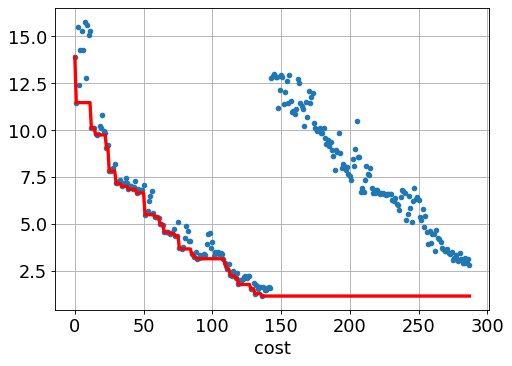

In [18]:
pl.figure(figsize=(7, 5), dpi=80)
matplotlib.rcParams.update({'font.size': 16})
pl.plot([t[1] for t in history], ".", lw=0.5, markersize=8)
pl.xlabel("cost")

pl.plot(np.minimum.accumulate([t[1] for t in history]), 'r', lw=3)
# pl.ylabel("function value")
# pl.ylim([0, 35])
pl.grid(True)

## Minima of GD

In [19]:
Xtr[0], Xtr[1], 

(array([ 5.9586,  8.1181,  2.6224,  1.2547,  0.2775,  4.4942, -0.5692,
         8.1281,  4.7002,  0.0801]),
 array([ 5.9586,  8.1181,  2.6224,  1.2547,  0.2775,  4.4942, -0.5692,
         8.1281,  4.7002,  2.6227]))

In [19]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

(array([1.0371, 0.2795, 0.7825, 0.9545, 1.0633, 0.9723, 3.6226, 1.0092,
        3.6804, 1.5064]),
 1.0510393584239275,
 109)

In [20]:
gp.get_normal()

(1.981279473567873, 1.277269082446665)

In [19]:
# # only for backtracking
# pl.figure(figsize=(10, 6), dpi=80)
# # pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### TuRBO

array([1.7104])

### *Thompson Sampling, UCB*

In [17]:
### Thompson Sampling
import os
gp.clear()
# gp.set_hyper(ls, var) # if online update hyper, skip

# init cost
# X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = X_fix

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

history_ucb = []
for a in X_fix:
    history_ucb.append( (a, f(a)) )

In [21]:
cost = setup 

while cost < MAX:
    # 1. Thompson Sampling
    w = gp.thompson_sample(n_mesh=2000)
    # 2. GP_UCB
#     b = np.log(cost**gp.dim)
#     w, fw = gp.ucb_minimize(b)
#     w, fw = gp.EI_minimize(y_best=np.min(f(gp.X)))
    if is_new(w, gp.X) == False:
        print('visit before, ignore ', w)
        continue
    

#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(24, 21))

#     # plot function (ax1, ax2)
#     im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax2)

#     im1 = ax1.contour(X1, X2, functions.Ackley_2().func(Grid).reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax1)
#     fig.colorbar(im2, ax=ax1)

#     ax1.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax1.plot(w[0], w[1], 'ro')
#     ax1.title.set_text("Noisy Ackley")
#     ax2.title.set_text("Standard Deviation")
    
    
#     # plot derivative in (ax3, ax4), (ax5, ax6)
#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, g1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

    
#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, g2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")

#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('2D_Plots/Ackley/' + filename)
#     pl.show()  
    print(cost, end = '. ')
    print('w: ', w)
    print('  f(w): ', f(w).item())
    print('  y_best: ', np.min(f(gp.X)))
    print()
    
    history_ucb.append( (w, f(w)) )
    gp.add_data(w.reshape(1, dim), f(w))
    
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    cost += 1

10. w:  [-2.9708  7.9098  9.4221 -4.0053  1.6135 -3.4827 -4.0064 -4.5825  6.7736
  3.2006]
  f(w):  14.750124728125018
  y_best:  12.745884822492366

11. w:  [ 3.4942  0.8941  2.9477  1.1468  2.9419  9.0332  8.535   5.0797 -3.0149
 -1.6345]
  f(w):  13.534869049727783
  y_best:  12.745884822492366

12. w:  [ 3.1126e-02  4.6312e-01  5.9026e+00 -3.6032e+00  7.7876e+00  9.6626e+00
  5.1374e+00  2.2563e-03  3.3669e-01  5.2061e+00]
  f(w):  14.321720718351742
  y_best:  12.745884822492366

  # Optimal (ls, var) =  (0.6426335219372731, 0.9999999818513834)
13. w:  [ 5.9089 -0.899  -1.6398 -3.0889  6.2784  2.5464  1.6812  3.4562  8.7511
  1.3984]
  f(w):  13.434938602650307
  y_best:  12.745884822492366

14. w:  [-3.1661  9.0737  7.7185  9.0847  0.857   4.8028 -0.5554  2.016   0.4084
  8.0717]
  f(w):  14.988935800406532
  y_best:  12.745884822492366

15. w:  [-3.921   1.4678 -4.6091  9.5364  0.286   8.5358 -0.8271  0.1427  0.914
  9.9346]
  f(w):  15.083842228605235
  y_best:  12.745884822492

59. w:  [ 4.9879  3.3068  9.9317 -0.1059 -3.6545  1.5059  5.7612  3.9657  2.2322
  3.4209]
  f(w):  13.706411634689882
  y_best:  9.647632107904009

60. w:  [ 0.4492 -3.2203  4.7759  3.5798  5.838  -4.3799  0.9159  9.025  -3.5863
 -1.8605]
  f(w):  13.510822959553572
  y_best:  9.647632107904009

  # Optimal (ls, var) =  (0.9772620664418414, 0.9999999759931035)
61. w:  [ 8.5755  7.9293 -1.1431  0.6078 -2.5505  8.2137  7.6275 -0.3505  4.3384
 -0.6356]
  f(w):  15.184916808573336
  y_best:  9.647632107904009

62. w:  [ 4.8916 -4.9046  5.4557  7.7557 -4.3698  1.3536 -1.1063  2.0261  0.897
  3.2907]
  f(w):  12.885730268811445
  y_best:  9.647632107904009

63. w:  [-0.3909  3.5814  2.9704  0.7839  7.8519  1.0819  4.4976 -1.0415  7.7077
  6.3674]
  f(w):  13.653844904387608
  y_best:  9.647632107904009

  # Optimal (ls, var) =  (0.20581195458945886, 0.9999999649915683)
64. w:  [-0.0161  4.3573  9.0148 -2.5212 -2.3173 -4.3924  7.6042  1.7851  3.9109
  0.8288]
  f(w):  13.69635897703931
  y_b

108. w:  [ 8.9659  1.4594  4.8498  9.7979  5.5023  5.6196 -2.6438 -1.9207 -0.6272
  2.3683]
  f(w):  14.962241725194941
  y_best:  9.647632107904009

  # Optimal (ls, var) =  (0.5405869325550121, 0.9999997917718901)
109. w:  [ 0.904   2.4655  8.8249  4.5083  4.5666 -2.6822  0.975   1.0449  1.8887
 -2.349 ]
  f(w):  12.351243019189447
  y_best:  9.647632107904009

110. w:  [-3.7682 -1.477   9.0385  3.5885  6.4691  4.8319 -2.9018  6.8395  5.9398
  0.0217]
  f(w):  14.372970241652068
  y_best:  9.647632107904009

111. w:  [ 3.2503  3.4048  7.2971  5.9731 -2.2325  0.9552  6.9746  5.3146 -4.6826
  6.7321]
  f(w):  14.41497781135115
  y_best:  9.647632107904009

  # Optimal (ls, var) =  (0.4141303199509775, 0.9999997999783554)
112. w:  [ 5.0637 -2.5097  1.4028  8.0104  7.587   4.1263  8.7855  2.245   0.3354
 -2.8714]
  f(w):  14.511788332113944
  y_best:  9.647632107904009

113. w:  [ 1.7115 -0.3857  1.7157  0.9161  0.988   1.3037 -3.8065  8.459   8.0337
 -0.8547]
  f(w):  12.612649206980592

157. w:  [ 8.0071 -0.546  -1.6022  3.5097 -0.2311 -1.915   2.1834  2.9473  5.4076
 -0.8743]
  f(w):  11.852825974210488
  y_best:  8.561644727531025

158. w:  [ 8.1743  4.9979 -0.2292  7.215   4.4802  1.3067 -2.8826  2.4956 -4.4612
  2.571 ]
  f(w):  13.81618339211242
  y_best:  8.561644727531025

159. w:  [-1.8272 -2.7431  1.3168  7.8705  2.3147 -0.4539  7.368  -3.6816  0.5337
  7.705 ]
  f(w):  13.937053389112867
  y_best:  8.561644727531025

  # Optimal (ls, var) =  (0.11335976919392692, 1.0000001613746003)
160. w:  [1.2842 8.333  6.724  8.5464 4.1216 7.7735 6.7484 8.1427 6.8795 1.3261]
  f(w):  16.319074838383333
  y_best:  8.561644727531025

161. w:  [-1.3369  0.2036 -4.5978  1.3343 -3.391   6.0568 -2.4938  9.4119  0.7552
  6.2504]
  f(w):  13.948614978448248
  y_best:  8.561644727531025

162. w:  [ 9.6474  2.899  -2.5886  1.455   7.0048 -3.379   1.5569  8.5708  8.2226
  3.6298]
  f(w):  15.658503229528659
  y_best:  8.561644727531025

  # Optimal (ls, var) =  (0.9023521054070449,

206. w:  [-4.256  -3.6885  1.6796  8.0072  4.1123  0.5884 -3.4658  0.5544  4.3569
  3.2187]
  f(w):  12.880564075571979
  y_best:  8.561644727531025

207. w:  [-0.3621 -2.5829  8.243  -1.8504 -4.1462 -2.1817  2.0913  7.2818 -4.0397
 -3.7482]
  f(w):  13.123244750528434
  y_best:  8.561644727531025

  # Optimal (ls, var) =  (0.7056917247126596, 0.9999999973367932)
208. w:  [-4.5288 -0.0347  0.4526  3.2929 -0.8281  0.6536 -3.9818  4.9883  5.4929
 -1.6464]
  f(w):  11.38868105550549
  y_best:  8.561644727531025

209. w:  [-4.6335  5.9896  6.0151  2.9782  4.341  -2.5491  7.3855  5.5177  2.3968
  6.2013]
  f(w):  14.593632509956668
  y_best:  8.561644727531025

210. w:  [ 6.1281 -4.5432  7.2625  7.323   5.8744 -1.7453  2.9082  7.7809  8.9607
 -4.729 ]
  f(w):  15.638364420091523
  y_best:  8.561644727531025

  # Optimal (ls, var) =  (0.6541203690178549, 0.999999951620793)
211. w:  [ 5.1225 -1.5263 -1.0112  7.3467  1.54    6.9994 -1.609   4.6814  8.0811
  2.3548]
  f(w):  14.129977876508057


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/hangdong/anaconda3/envs/BO/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-46d9a4d6ddf1>", line 72, in <module>
    ls, var = gp.optimize()
  File "/home/hangdong/gp/Code/GP.py", line 150, in optimize
    loglik = np.append(loglik, self.log_lik(hyper_values=x))
  File "/home/hangdong/gp/Code/GP.py", line 126, in log_lik
    KK_x_x = self.cov_RBF(self._X, self._X, hyper) + np.eye(len(self._X)) * self.noise_delta**2
  File "/home/hangdong/gp/Code/GP.py", line 113, in cov_RBF
    assert np.all(x2 >= self._B[:, 0]) and np.all(x2 <= self._B[:, 1])
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hangdong/anaconda3/envs/BO/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_trace

TypeError: object of type 'NoneType' has no len()

In [17]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot(np.squeeze(np.array(history_ucb)[:, 1]), "-^", lw=0.5)
pl.plot(np.minimum.accumulate(np.array(history_ucb)[:, 1]), 'r', lw=2)
pl.xlabel("cost")
pl.ylabel("function value")
pl.grid(True)

NameError: name 'history_ucb' is not defined

<Figure size 800x560 with 0 Axes>

## Global Minima 

In [ ]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

In [ ]:
gp.get_hyper()

In [ ]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot(np.minimum.accumulate([t[1].item() for t in history_ucb]), 'r', lw=3, label='Thompson')
pl.plot(np.minimum.accumulate([t[1].item() for t in history]), 'b', lw=3, label='GD')
# pl.title("6D Hartmann function on [0, 1]")
pl.legend()
pl.grid(True)
# pl.ylim([0, 100])

In [ ]:
import pickle
file_name = "./pkl/GD_Ackley5.pkl" 

open_file = open(file_name, "wb")
pickle.dump(np.minimum.accumulate([t[1] for t in history]), open_file)
open_file.close()

open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

In [ ]:
file_name = "./pkl/thompson_Ackley5.pkl" 

open_file = open(file_name, "wb")
pickle.dump(np.minimum.accumulate([t[1] for t in history_ucb]), open_file)
open_file.close()

open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()